## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data quality check
*By Julia

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

sns.set_theme(style='white', palette='rainbow', font_scale=1.2)
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("data/student-mat.csv")
display(data.head())
display(data.shape)

#check missing data -> There are no missing data
print(f"Length: {len(data)}")
print(f"Shape: {data.shape}")
print(f"Columns: {data.columns}")
#data.isnull().any()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


(395, 33)

Length: 395
Shape: (395, 33)
Columns: Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')


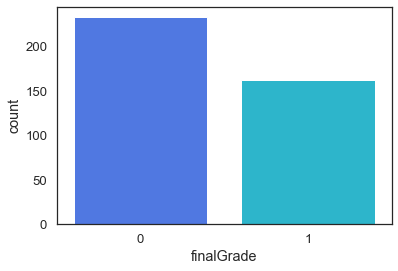

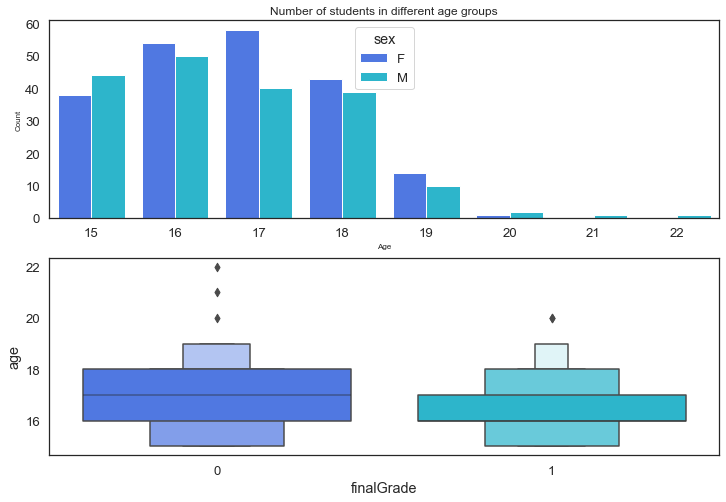

In [3]:
### Age & Gender Distribution and its effect on grade outcome

### Marking Final Grade as Categorical Value & Viewing their Count
data['finalGrade'] = np.where(data['G3'] >= 12, 'Pass', 'Fail')
data['finalGrade'].replace(['Fail', 'Pass'], [0, 1], inplace=True)
sns.countplot(x='finalGrade', data=data)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

age_pl = sns.countplot(data=data, x='age', hue='sex', ax=axes[0])
age_pl.axes.set_title('Number of students in different age groups', fontsize=12)
age_pl.set_xlabel("Age", fontsize=8)
age_pl.set_ylabel("Count", fontsize=8)

sns.boxenplot(x='finalGrade', y='age', data=data, ax=axes[1])
plt.show()

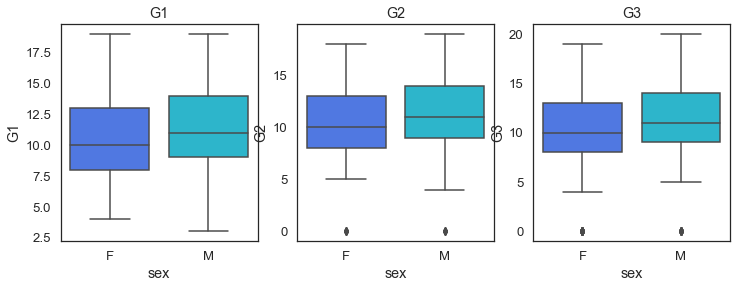

In [4]:
#Whether there's a gender difference in grade distribution in G1 G2 AND G3
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax1 = sns.boxplot(data=data, x='sex', y='G1', ax=axes[0])
ax1.set_title('G1')
ax2 = sns.boxplot(data=data, x='sex', y='G2', ax=axes[1])
ax2.set_title('G2')
ax3 = sns.boxplot(data=data, x='sex', y='G3', ax=axes[2])
ax3.set_title('G3')
plt.show()

Text(0.5, 0, 'age')

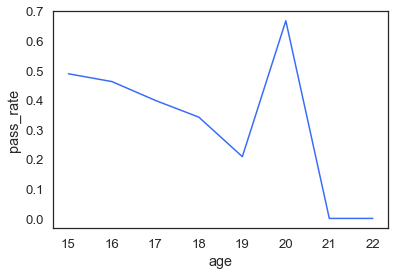

In [5]:
age_data = data.groupby('age')['finalGrade'].agg([('pass_rate', 'mean'), ('nobs', 'count')]).reset_index(drop=False)
sns.lineplot(x=age_data.age, y=age_data['pass_rate'])
plt.xlabel('age')


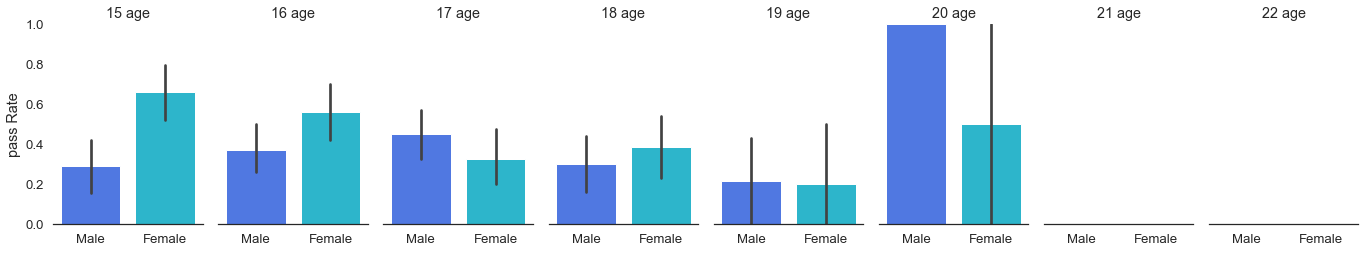

In [6]:
g = sns.catplot(
    data=data, x="sex", y="finalGrade", col="age",
    kind="bar", height=4, aspect=.6,
)
g.set_axis_labels("", "pass Rate")
g.set_xticklabels(["Male", "Female"])
g.set_titles("{col_name} {col_var}")
g.set(ylim=(0, 1))
g.despine(left=True)

Text(0, 0.5, 'Count')

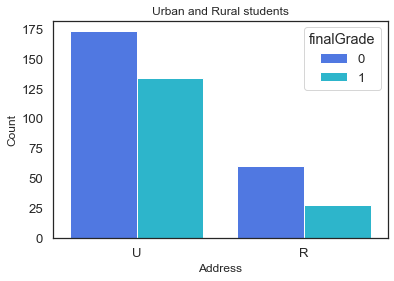

In [7]:
#Whether geography affects grade outcome 
add_plt = sns.countplot(data=data, x='address', hue="finalGrade")
add_plt.axes.set_title('Urban and Rural students', fontsize=12)
add_plt.set_xlabel('Address', fontsize=12)
add_plt.set_ylabel('Count', fontsize=12)

Text(0.5, 0.98, 'Educated families result in Potentail higher grades in G1 & G2')

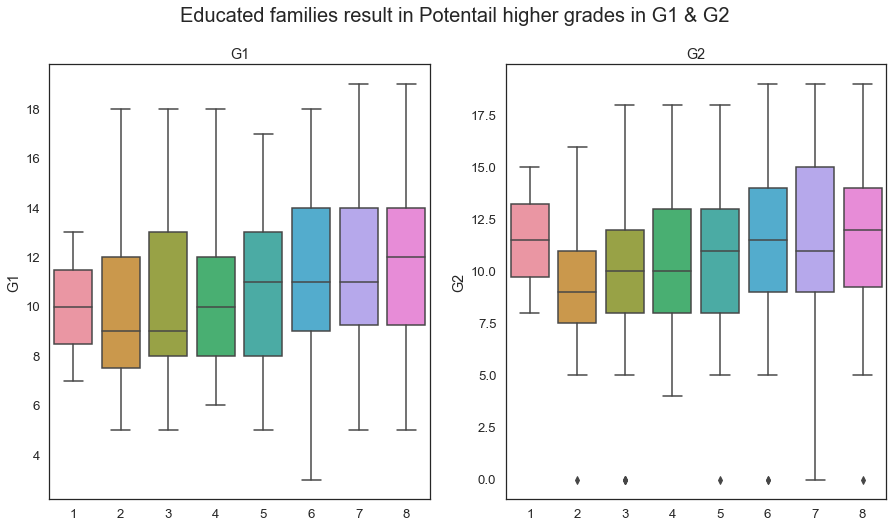

In [8]:
### Parents Education and its potential relationship with educational outcome
#Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)
#Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)

family_ed = data['Fedu'] + data['Medu']
# add_plt = sns.countplot(data = data, x =family_ed, hue = "Final Grade")

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
ax1 = sns.boxplot(data=data, x=family_ed, y='G1', ax=axes[0])
ax1.set_title('G1')
ax2 = sns.boxplot(data=data, x=family_ed, y='G2', ax=axes[1])
ax2.set_title('G2')

fig.suptitle('Educated families result in Potentail higher grades in G1 & G2', fontsize=20)

### Data cleaning
*By Xena Valenzuela*

From the data quality check we realized that:

1. Some of the columns that should have contained only numeric values, specifically <>, <>, and <> have special characters such as \*, #, %. We'll remove these characters, and convert the datatype of these columns to numeric.

2. Some of the columns have more than 60% missing values, and it is very difficult to impute their values, as the values seem to be missing at random with negligible association with other predictors. We'll remove such columns from the data.

3. The column `number_of_bedrooms` has some unreasonably high values such as 15. As our data consist of single-family homes in Evanston, we suspect that any value greater than 5 may be incorrect. We'll replace all values that are greater than 5 with an estimate obtained using the $K$-nearest neighbor approach.

4. The columns `house_price` has some unreasonably high values. We'll tag all values greater than 1 billion dollars as "potentially incorrect observation", to see if they distort our prediction / inference later on.

The code below implements the above cleaning.

In [9]:
#...Code with comments...#

### Data preparation
*By Sankaranarayanan Balasubramanian and Chun-Li*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have shuffled the dataset to prepare it for K-fold cross validation.

3. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [10]:
######---------------Creating new predictors----------------#########

#Creating number of bedrooms per unit floor area

#Creating ratio of bathrooms to bedrooms

#Creating ratio of carpet area to floor area

In [11]:
######-----------Shuffling the dataset for K-fold------------#########

In [12]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.